In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

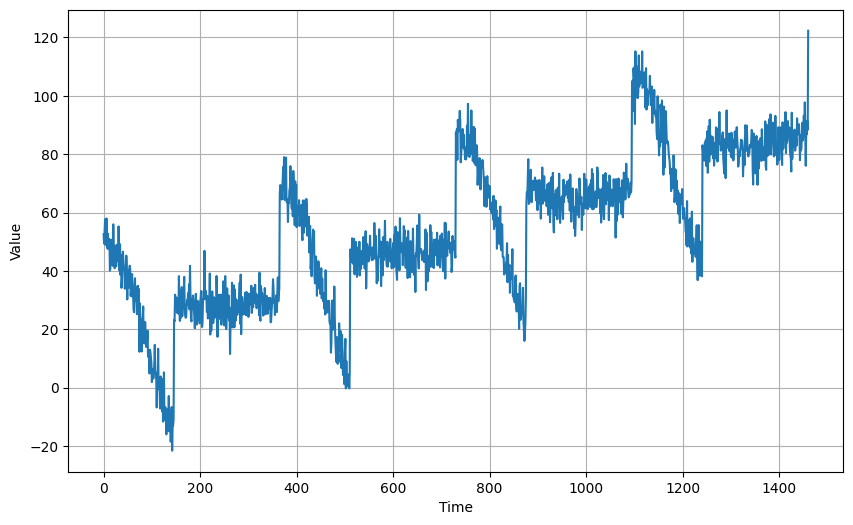

In [5]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [6]:

split_time =1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
def windowed_dataset(series, window_size, batch_size, buffer_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window : window.batch(window_size+1))
    dataset = dataset.map(lambda window : (window[:-1], window[-1]))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [11]:
window_size = 20
batch_size = 32
shuffle_buffer_size =1000

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [13]:
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_baseline.summary()

/Users/geonheekim/Desktop/study/LLM/prompt_test/DeeplearningAI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model_baseline.compile(loss='mse',
                       optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6,
                                                           momentum=0.9))


In [16]:
model_baseline.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 2548.3496
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 114.1797
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 81.3658
Epoch 4/100


2024-04-18 10:39:37.724099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/geonheekim/miniforge3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-18 10:39:37.800753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:37.876487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 74.1213
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 66.4539
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 68.4866
Epoch 7/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 66.3792

2024-04-18 10:39:37.944310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.010813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.078420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.146988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 66.6962
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 68.0251
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 66.1229
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 64.0377
Epoch 11/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 45.0363

2024-04-18 10:39:38.243037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.315262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.385014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 62.5098
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 61.3101
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 62.0459
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 52.0556


2024-04-18 10:39:38.452833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.520039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.586610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.653359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 55.6270
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 51.7545
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 54.0316
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 54.1810
Epoch 19/100


2024-04-18 10:39:38.719429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.785431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.851367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:38.915845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 54.8020
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 50.8557
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 57.5310
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 51.2078


2024-04-18 10:39:38.982746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.047159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.112569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.182758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 51.9969
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 54.5088
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 56.8154
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 45.0821
Epoch 27/100


2024-04-18 10:39:39.262950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.328244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.393597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.459490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 51.9073
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 49.5427
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 51.0331
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 53.8538


2024-04-18 10:39:39.527812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.595458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.662435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.728649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 53.0955
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 53.3381
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 54.0609
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 48.0237


2024-04-18 10:39:39.796008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.862329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.928187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:39.995598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 42.1317
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 55.7050
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 50.7856
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 48.1456
Epoch 39/100


2024-04-18 10:39:40.063737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.128996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.194893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.260354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 55.6921
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 49.3739
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 47.6618
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 48.8879
Epoch 43/100


2024-04-18 10:39:40.328541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.394901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.459593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.523539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 53.3891
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 46.0493
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 44.0192
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 43.3569
Epoch 47/100


2024-04-18 10:39:40.588735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.655262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.719626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.786413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 50.4843
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 47.2886
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 50.2196
Epoch 50/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 48.8398

2024-04-18 10:39:40.855751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.927242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:40.993851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 45.4632
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 42.0782
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 47.5752
Epoch 53/100


2024-04-18 10:39:41.060805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:41.127286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:41.216540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 45.9186
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 52.7083
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 48.8941
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 58.0511
Epoch 57/100


2024-04-18 10:39:41.281963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:41.346298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:41.410672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:41.475049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 43.6020
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 46.5217
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 46.6585
Epoch 60/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 59.3085

2024-04-18 10:39:41.541678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:41.608293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:41.676175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:41.742900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 48.7844
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 44.3465
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 46.1036
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 47.2468
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 48.0086
Epoch 65/100


2024-04-18 10:39:41.809079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:41.872720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:41.937187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.004071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 40.7594
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 44.5353
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 46.2201
Epoch 68/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 22.4703

2024-04-18 10:39:42.075152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.144704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.211156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 42.6269
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 43.4338
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 47.4578
Epoch 71/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 36.0206

2024-04-18 10:39:42.278727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.346737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.416397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.481088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 41.6817
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 47.6262
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 43.1638
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 46.5663
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 44.3580
Epoch 76/100


2024-04-18 10:39:42.546808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.612604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.677899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.742225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 41.6537
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 42.9177
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 48.4311
Epoch 79/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 49.9187

2024-04-18 10:39:42.809944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.876452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:42.945293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 45.9838
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 42.7845
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 43.1149
Epoch 82/100


2024-04-18 10:39:43.013917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:43.107911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:43.174164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 45.2343
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 44.0030
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 46.8619
Epoch 85/100


2024-04-18 10:39:43.238942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:43.321094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:43.390003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 49.2993
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 44.8081
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 44.9416
Epoch 88/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 38.7077

2024-04-18 10:39:43.457792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:43.527458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:43.594533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:43.659552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 45.3556
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 40.9609
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 45.9076
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 51.7017
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 43.6952
Epoch 93/100


2024-04-18 10:39:43.728350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:43.792858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:43.857398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:43.925874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 46.7271
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 43.3922
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 47.1046
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 43.5897
Epoch 97/100


2024-04-18 10:39:44.016413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:44.081125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:44.146412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:44.211463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 41.5706
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 40.9733
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 39.2016
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 44.3491


2024-04-18 10:39:44.276530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:44.341769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:44.405375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:39:44.469731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


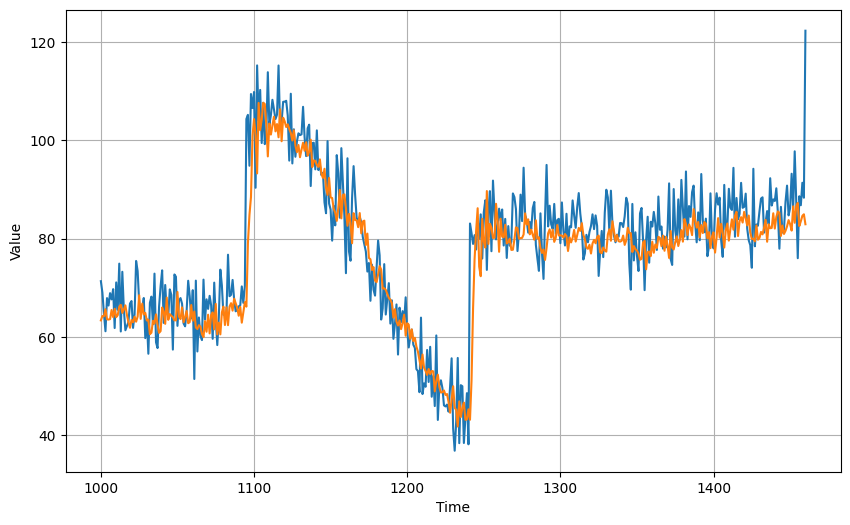

In [17]:
forecast = []

forecast_series = series[split_time-window_size:]

for time in range(len(forecast_series)-window_size):
    forecast.append(model_baseline.predict(forecast_series[time:time+window_size][np.newaxis]))
    
results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))

In [18]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())


50.47491
5.1362295


In [23]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

/Users/geonheekim/Desktop/study/LLM/prompt_test/DeeplearningAI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

In [29]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_tune.compile(optimizer=optimizer,
                   loss='mse')

In [30]:
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 474.2057 - learning_rate: 1.0000e-08
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 181.3029 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 118.3595 - learning_rate: 1.2589e-08
Epoch 4/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 92.6504

2024-04-18 10:54:29.333825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/geonheekim/miniforge3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-18 10:54:29.405912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:29.476958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 95.9112 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 100.4823 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 98.6996 - learning_rate: 1.7783e-08
Epoch 7/100


2024-04-18 10:54:29.546580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:29.619094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:29.687905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 99.6509 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 88.5978 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 94.4896 - learning_rate: 2.5119e-08
Epoch 10/100


2024-04-18 10:54:29.763920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:29.868421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:29.940243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 94.0060 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 90.2151 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 107.0107 - learning_rate: 3.5481e-08
Epoch 13/100


2024-04-18 10:54:30.014530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:30.085437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:30.181633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 88.7919 - learning_rate: 3.9811e-08
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 92.8777 - learning_rate: 4.4668e-08
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 87.6434 - learning_rate: 5.0119e-08
Epoch 16/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 84.5767

2024-04-18 10:54:30.249550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:30.318212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:30.385591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 85.4099 - learning_rate: 5.6234e-08
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 83.6674 - learning_rate: 6.3096e-08
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 93.5297 - learning_rate: 7.0795e-08
Epoch 19/100


2024-04-18 10:54:30.457210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:30.536668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:30.607148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 83.5270 - learning_rate: 7.9433e-08
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 89.0353 - learning_rate: 8.9125e-08
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 91.6138 - learning_rate: 1.0000e-07
Epoch 22/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 73.9473

2024-04-18 10:54:30.679826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:30.752930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:30.819371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 82.6935 - learning_rate: 1.1220e-07
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 84.0307 - learning_rate: 1.2589e-07
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 86.9516 - learning_rate: 1.4125e-07
Epoch 25/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 63.1802

2024-04-18 10:54:30.887957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:30.955696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:31.024171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 79.2496 - learning_rate: 1.5849e-07
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 75.3645 - learning_rate: 1.7783e-07
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 79.8986 - learning_rate: 1.9953e-07
Epoch 28/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 83.4905

2024-04-18 10:54:31.096568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:31.167507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:31.236674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 76.5051 - learning_rate: 2.2387e-07
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 78.5021 - learning_rate: 2.5119e-07
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 69.9173 - learning_rate: 2.8184e-07
Epoch 31/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 63.1711

2024-04-18 10:54:31.304386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:31.373094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:31.442254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 67.3775 - learning_rate: 3.1623e-07
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 68.5126 - learning_rate: 3.5481e-07
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 80.2438 - learning_rate: 3.9811e-07
Epoch 34/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 131.6852

2024-04-18 10:54:31.514295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:31.584963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:31.654204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 72.9750 - learning_rate: 4.4668e-07
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 62.7840 - learning_rate: 5.0119e-07
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 62.7188 - learning_rate: 5.6234e-07
Epoch 37/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 51.9444

2024-04-18 10:54:31.722707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:31.790105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:31.857434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 60.1236 - learning_rate: 6.3096e-07
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 60.8743 - learning_rate: 7.0795e-07
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 60.1299 - learning_rate: 7.9433e-07
Epoch 40/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 43.8723

2024-04-18 10:54:31.925439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:31.998522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:32.069122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 53.7978 - learning_rate: 8.9125e-07
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 59.8591 - learning_rate: 1.0000e-06
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 54.5535 - learning_rate: 1.1220e-06
Epoch 43/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 35.4709

2024-04-18 10:54:32.135801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:32.203515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:32.269525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:32.338085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 48.3626 - learning_rate: 1.2589e-06
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 52.2287 - learning_rate: 1.4125e-06
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 50.3343 - learning_rate: 1.5849e-06
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 46.2917 - learning_rate: 1.7783e-06
Epoch 47/100


2024-04-18 10:54:32.410447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:32.483659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:32.554341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 53.6908 - learning_rate: 1.9953e-06
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 56.7294 - learning_rate: 2.2387e-06
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 46.0631 - learning_rate: 2.5119e-06
Epoch 50/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 47.0528

2024-04-18 10:54:32.626523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:32.698096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:32.762994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:32.828253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 50.1537 - learning_rate: 2.8184e-06
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 52.7410 - learning_rate: 3.1623e-06
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 52.0944 - learning_rate: 3.5481e-06
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 52.8587 - learning_rate: 3.9811e-06
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 48.7111 - learning_rate: 4.4668e-06


2024-04-18 10:54:32.894457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:32.961374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.028094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.093660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 48.1883 - learning_rate: 5.0119e-06
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 63.5269 - learning_rate: 5.6234e-06
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 46.7407 - learning_rate: 6.3096e-06
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 59.7180 - learning_rate: 7.0795e-06
Epoch 59/100


2024-04-18 10:54:33.158536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.224468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.290747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.357333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 47.9651 - learning_rate: 7.9433e-06
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 45.5430 - learning_rate: 8.9125e-06
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 49.9875 - learning_rate: 1.0000e-05
Epoch 62/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 47.3534

2024-04-18 10:54:33.423942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.489757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.559900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 46.9203 - learning_rate: 1.1220e-05
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 48.3283 - learning_rate: 1.2589e-05
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 50.7783 - learning_rate: 1.4125e-05
Epoch 65/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 66.4585

2024-04-18 10:54:33.631712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.699721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.771408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 53.0626 - learning_rate: 1.5849e-05
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 53.0511 - learning_rate: 1.7783e-05
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 49.3993 - learning_rate: 1.9953e-05
Epoch 68/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 46.0532

2024-04-18 10:54:33.841338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.915283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:33.985945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 50.4874 - learning_rate: 2.2387e-05
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 49.9862 - learning_rate: 2.5119e-05
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 55.1628 - learning_rate: 2.8184e-05
Epoch 71/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 31.0000

2024-04-18 10:54:34.052977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:34.120062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:34.187206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:34.255079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 48.6095 - learning_rate: 3.1623e-05
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 56.0835 - learning_rate: 3.5481e-05
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 71.0373 - learning_rate: 3.9811e-05
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 64.4254 - learning_rate: 4.4668e-05
Epoch 75/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 109.3699

2024-04-18 10:54:34.322208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:34.388844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:34.455927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:34.523569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 98.2401 - learning_rate: 5.0119e-05
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 914.9464 - learning_rate: 5.6234e-05
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 2163.2039 - learning_rate: 6.3096e-05
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 4514.3882 - learning_rate: 7.0795e-05
Epoch 79/100


2024-04-18 10:54:34.590680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:34.656504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:34.723294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 1646.2881 - learning_rate: 7.9433e-05
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 493.9317 - learning_rate: 8.9125e-05
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 401.6252 - learning_rate: 1.0000e-04
Epoch 82/100


2024-04-18 10:54:34.820377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:34.910583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:34.976112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 361.3307 - learning_rate: 1.1220e-04
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 355.5582 - learning_rate: 1.2589e-04
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 361.5606 - learning_rate: 1.4125e-04
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 374.2171 - learning_rate: 1.5849e-04
Epoch 86/100


2024-04-18 10:54:35.043127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.109789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.176262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.241447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 362.0873 - learning_rate: 1.7783e-04
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 375.4305 - learning_rate: 1.9953e-04
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 375.5723 - learning_rate: 2.2387e-04
Epoch 89/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 394.7504

2024-04-18 10:54:35.308636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.375652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.441834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.509444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 380.8912 - learning_rate: 2.5119e-04
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 357.1276 - learning_rate: 2.8184e-04
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 376.6385 - learning_rate: 3.1623e-04
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 401.3810 - learning_rate: 3.5481e-04
Epoch 93/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 266.4725

2024-04-18 10:54:35.577459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.642324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.711998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 376.9808 - learning_rate: 3.9811e-04
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 373.1941 - learning_rate: 4.4668e-04
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 391.6422 - learning_rate: 5.0119e-04
Epoch 96/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 337.5876

2024-04-18 10:54:35.783941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.854572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.920971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:35.986288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 367.9778 - learning_rate: 5.6234e-04
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 373.1674 - learning_rate: 6.3096e-04
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 393.8031 - learning_rate: 7.0795e-04
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 387.4046 - learning_rate: 7.9433e-04
Epoch 100/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 365.3868

2024-04-18 10:54:36.056364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:36.129361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 10:54:36.198791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 377.7163 - learning_rate: 8.9125e-04


2024-04-18 10:54:36.264478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-08, 0.001, 0.0, 300.0)

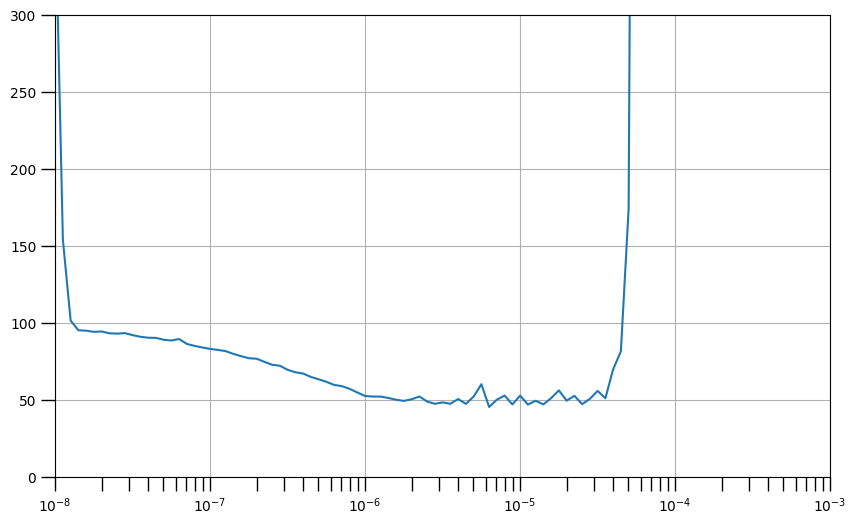

In [31]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=1e-6))

history = model.fit(dataset, epochs=100)

Epoch 1/100


/Users/geonheekim/Desktop/study/LLM/prompt_test/DeeplearningAI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 2530.3865
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 108.6048
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 70.5763
Epoch 4/100


2024-04-18 11:30:06.865444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/geonheekim/miniforge3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-18 11:30:06.941316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:07.015767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 63.5382
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 63.3267
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 64.3683
Epoch 7/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 59.1994

2024-04-18 11:30:07.087221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:07.158702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:07.226580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 57.8770
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 60.0400
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 54.2427
Epoch 10/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 39.2137

2024-04-18 11:30:07.295161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:07.363384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:07.431110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 55.5917
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 51.1886
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 63.9891
Epoch 13/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 86.4873

2024-04-18 11:30:07.499502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:07.571904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:07.641602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 57.0542
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 54.7920
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 55.7704
Epoch 16/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 57.9703

2024-04-18 11:30:07.709418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:07.776281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:07.842408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:07.911445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 57.0209
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 54.8478
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 49.4044
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 58.0279
Epoch 20/100


2024-04-18 11:30:07.985901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:08.059061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:08.131411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 57.7413
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 50.5097
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 53.8072
Epoch 23/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 53.5583

2024-04-18 11:30:08.201283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:08.270556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:08.338814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 50.4188
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 56.0295
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 54.5557
Epoch 26/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 107.5555

2024-04-18 11:30:08.409041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:08.479375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:08.551302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 63.2940
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 54.1148
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 54.7893
Epoch 29/100


2024-04-18 11:30:08.620076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:08.692876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:08.766425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 53.6235
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 57.9604
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 47.0238
Epoch 32/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 58.3769

2024-04-18 11:30:08.842577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:08.909553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:08.976935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 45.7877
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 56.1528
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 53.4330
Epoch 35/100


2024-04-18 11:30:09.047030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:09.120825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:09.195176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 51.5406
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 50.1055
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 47.0393
Epoch 38/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 51.3007

2024-04-18 11:30:09.264152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:09.332012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:09.400920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 59.5086
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 45.5567
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 46.9339
Epoch 41/100


2024-04-18 11:30:09.470879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:09.540658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:09.622206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 51.2551
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 46.1113
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 44.9773
Epoch 44/100


2024-04-18 11:30:09.693151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:09.765619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:09.837450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 51.3865
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 45.8502
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 42.5630
Epoch 47/100


2024-04-18 11:30:09.909525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:09.989853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:10.060569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 52.1903
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 46.7922
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 49.4194
Epoch 50/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 34.3965

2024-04-18 11:30:10.132822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:10.203159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:10.271717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 47.3700
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 44.4188
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 47.2381
Epoch 53/100


2024-04-18 11:30:10.341809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:10.418929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:10.488501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 50.1928
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 49.3167
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 56.5125
Epoch 56/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 32.4412

2024-04-18 11:30:10.555875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:10.626634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:10.696015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 51.7334
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 46.4042
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 46.5312
Epoch 59/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 64.1004

2024-04-18 11:30:10.764355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:10.832931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:10.903022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 46.8606
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 45.2115
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 47.8558
Epoch 62/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 54.7776

2024-04-18 11:30:10.973258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:11.044063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:11.114428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 49.1276
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 52.3951
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 47.2215
Epoch 65/100


2024-04-18 11:30:11.183333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:11.253265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:11.321995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 49.7562
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 45.0948
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 42.2295
Epoch 68/100


2024-04-18 11:30:11.397919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:11.490152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:11.556574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 47.3241
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 53.4061
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 44.2840
Epoch 71/100


2024-04-18 11:30:11.629064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:11.713818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:11.782770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 49.3484
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 52.6740
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 45.4463
Epoch 74/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 27.6120

2024-04-18 11:30:11.853642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:11.922929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:11.991058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 46.6329
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 42.7865
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 44.9839
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 52.6979


2024-04-18 11:30:12.057161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:12.124448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:12.191400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:12.256984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 46.4834
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 44.7774
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 44.0027
Epoch 81/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 38.6165

2024-04-18 11:30:12.328744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:12.403196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:12.470050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 48.2201
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 47.3688
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 49.9285
Epoch 84/100


2024-04-18 11:30:12.536345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:12.609300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:12.679714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 52.1979
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 43.6294
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 48.6630
Epoch 87/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 61.9095

2024-04-18 11:30:12.749876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:12.818425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:12.884863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:12.951623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 50.0717
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 48.7765
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 43.5848
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 43.5500
Epoch 91/100


2024-04-18 11:30:13.021247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:13.094660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:13.167497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 44.4986
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 44.5788
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 47.2130
Epoch 94/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 54.3047

2024-04-18 11:30:13.237964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:13.308854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:13.377179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 44.7761
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 43.8314
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 46.6013
Epoch 97/100


2024-04-18 11:30:13.444630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:13.512603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:13.584461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 49.7364
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 43.9314
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 46.4002
Epoch 100/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 37.3106

2024-04-18 11:30:13.657246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:13.726684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-18 11:30:13.797046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 40.9228


2024-04-18 11:30:13.867659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


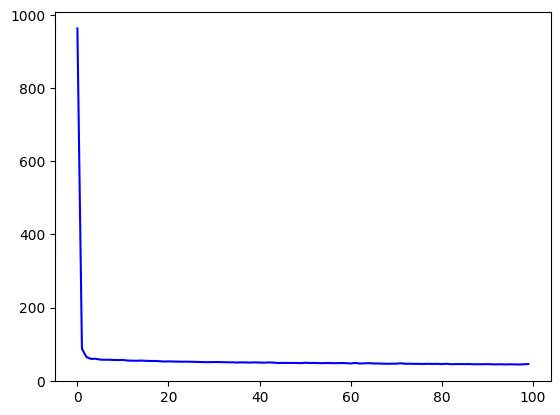

In [37]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

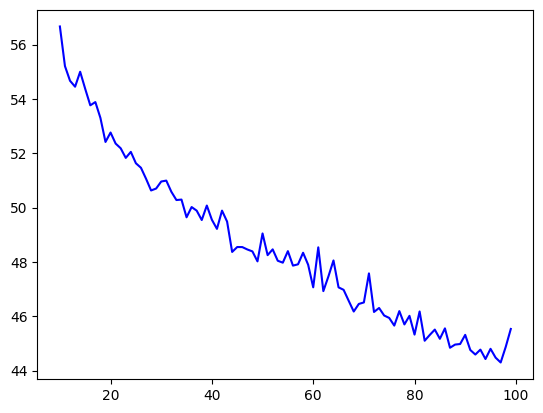

In [38]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

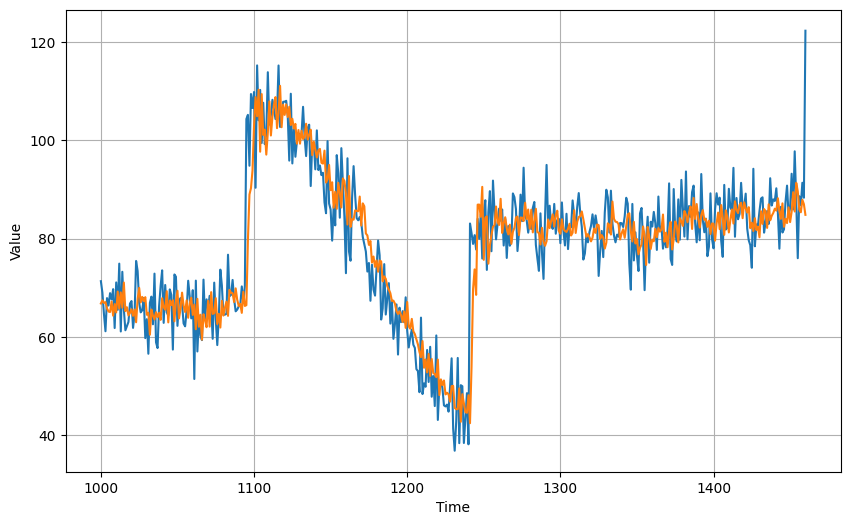

In [39]:
forecast = []

forecast_series = series[split_time-window_size:]

for time in range(len(forecast_series)-window_size):
    forecast.append(model.predict(forecast_series[time:time+window_size][np.newaxis]))

results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))

In [40]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

47.749836
5.098338
